# 🎉 External Input & Attractor Stimulation Simulation

---
## 🔍 Notebook objectives

This notebook contains simulation of 360 excitatory regular spiking (RS) neuron and 90 inhibitory fast spiking (FS) interneurons with weights being assigned as described in Compte et al. [paper](https://academic.oup.com/cercor/article/10/9/910/289091) (2000) (specifically for each group of neurons and even channel type) with external input modeled as uncorrelated Poisson spike trains.

# 🎒 Setup

## ⬇️ Imports

In [63]:
from utils.complete_simulation import network_simulation_run
from utils.poisson_spike_train_generation import generate_spike_train
from utils.plots import *

import numpy as np
import yaml #reading env consts

## 🛠️ Simulation Utils

In [64]:
#RS neuron parameters
with open('utils/RS.yaml', 'r', encoding="utf-8") as f:
    params_RS = yaml.load(f, Loader=yaml.FullLoader)

#FS neuron parameters
with open('utils/FS.yaml', 'r', encoding="utf-8") as f:
    params_FS = yaml.load(f, Loader=yaml.FullLoader)

#receptor kinetics parameters
with open('utils/receptor_kinetics.yaml', 'r', encoding="utf-8") as f:
    params_receptor_kinetics = yaml.load(f, Loader=yaml.FullLoader)

#synaptic weights parameters
with open('utils/synaptic_weights.yaml', 'r', encoding="utf-8") as f:
    params_synaptic_weights = yaml.load(f, Loader=yaml.FullLoader)

#external input parameters
with open('utils/external_input.yaml', 'r', encoding="utf-8") as f:
    params_external_input = yaml.load(f, Loader=yaml.FullLoader)

In [65]:
#simulation time
seconds = 2

t_min = 0
t_max = int(seconds*1000) #in ms -> 1(s) of simulation
sim_steps = int(seconds*10000)

T = np.linspace(t_min, t_max, sim_steps)
delta_T = t_max/sim_steps #always 0.1ms

# 🧪 Experiments

## 1️⃣ Random Background Input Without Any Attractor

### 🏋️ Synaptic Weights

In [93]:
#360 RS and 90 FS
Ne = 100
Ni = 25

weights = np.array(np.zeros((Ne + Ni, Ne + Ni))) #matrix (Ne + Ni) x (Ne + Ni) (i, j: i -> j), thus sum by column for input of j

for i in range(Ne):
    for j in range(Ne):
        if i != j:
            angle_i = i / Ne * 360
            angle_j = j / Ne * 360
            weights[i, j] = params_synaptic_weights['j'] + (params_synaptic_weights['j'] + params_synaptic_weights['j_ee']) * np.exp(-(min(max(angle_i, angle_j) - min(angle_i, angle_j), 360 - (max(angle_i, angle_j) - min(angle_i, angle_j))))**2/params_synaptic_weights['sigma']**2)

for i in range(Ne):
    for j in range(Ni):
        angle_i = i / Ne * 360
        angle_j = j / Ni * 360
        weights[i, Ne + j] = params_synaptic_weights['j'] + (params_synaptic_weights['j'] + params_synaptic_weights['j_ei']) * np.exp(-(min(max(angle_i, angle_j) - min(angle_i, angle_j), 360 - (max(angle_i, angle_j) - min(angle_i, angle_j))))**2/params_synaptic_weights['sigma']**2)

for i in range(Ni):
    for j in range(Ne):
        angle_i = i / Ni * 360
        angle_j = j / Ne * 360
        weights[Ne + i, j] = params_synaptic_weights['j'] + (params_synaptic_weights['j'] + params_synaptic_weights['j_ie']) * np.exp(-(min(max(angle_i, angle_j) - min(angle_i, angle_j), 360 - (max(angle_i, angle_j) - min(angle_i, angle_j))))**2/params_synaptic_weights['sigma']**2)

for i in range(Ni):
    for j in range(Ni):
        if i != j:
            angle_i = i / Ni * 360
            angle_j = j / Ni * 360
            weights[Ne + i, Ne + j] = params_synaptic_weights['j'] + (params_synaptic_weights['j'] + params_synaptic_weights['j_ii']) * np.exp(-(min(max(angle_i, angle_j) - min(angle_i, angle_j), 360 - (max(angle_i, angle_j) - min(angle_i, angle_j))))**2/params_synaptic_weights['sigma']**2)

### 🎯 Stimulus Representation

In [94]:
currents = np.array(np.zeros((len(T) + 1, Ne + Ni))) #no currents today!
#preferred angle - 90
# A = 10000
# mu = 10
# for i in range(Ne):
#     angle_i = i / Ne * 360
#     currents[(len(T) + 1)//3:(len(T) + 1)//2, i] = A * np.exp(mu * (np.cos(np.deg2rad(angle_i) - np.deg2rad(90)) - 1))

In [95]:
currents

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### 🚝 External Cortical Input

In [96]:
np.random.seed(42) #for reproducibility; the only source of randomness in the model

spike_trains = generate_spike_train(Ne, Ni, params_external_input['v_e'], params_external_input['v_i'], T, delta_T)

### 🥳 Serotonin Weights

In [97]:
serotonin_weights = np.ones(Ne + Ni)

### 🔩 Settings

In [98]:
start_state = np.column_stack((np.append(params_RS["v"]*np.ones(Ne), params_FS["v"]*np.ones(Ni)), np.append(params_RS["u"]*np.ones(Ne), params_FS["u"]*np.ones(Ni)))) #matrix (Ne + Ni) x 2 - (v, u) for each neuron

params_network = {"a": np.append(params_RS["a"]*np.ones(Ne), params_FS["a"]*np.ones(Ni)), 
          "b": np.append(params_RS["b"]*np.ones(Ne), params_FS["b"]*np.ones(Ni)), 
          "c": np.append(params_RS["c"]*np.ones(Ne), params_FS["c"]*np.ones(Ni)), 
          "d": np.append(params_RS["d"]*np.ones(Ne), params_FS["d"]*np.ones(Ni)), 
          "C": np.append(params_RS["C"]*np.ones(Ne), params_FS["C"]*np.ones(Ni)), 
          "k": np.append(params_RS["k"]*np.ones(Ne), params_FS["k"]*np.ones(Ni)),
          "v_peak": np.append(params_RS["v_peak"]*np.ones(Ne), params_FS["v_peak"]*np.ones(Ni)), 
          "v_r": np.append(params_RS["v_r"]*np.ones(Ne), params_FS["v_r"]*np.ones(Ni)), 
          "v_t": np.append(params_RS["v_t"]*np.ones(Ne), params_FS["v_t"]*np.ones(Ni)),
          "tau_ampa": params_receptor_kinetics["tau_ampa"]*np.ones((Ne + Ni, Ne + Ni)),
          "tau_nmda": params_receptor_kinetics["tau_nmda"]*np.ones((Ne + Ni, Ne + Ni)),
          "tau_gabaa": params_receptor_kinetics["tau_gabaa"]*np.ones((Ne + Ni, Ne + Ni)),
          "tau_gabab": params_receptor_kinetics["tau_gabab"]*np.ones((Ne + Ni, Ne + Ni)),
          "g_ee_ampa": params_synaptic_weights["g_ee_ampa"]*np.ones((Ne + Ni, Ne + Ni)),
          "g_ee_nmda": params_synaptic_weights["g_ee_nmda"]*np.ones((Ne + Ni, Ne + Ni)),
          "g_ei_ampa": params_synaptic_weights["g_ei_ampa"]*np.ones((Ne + Ni, Ne + Ni)),
          "g_ei_nmda": params_synaptic_weights["g_ei_nmda"]*np.ones((Ne + Ni, Ne + Ni)),
          "g_ie": params_synaptic_weights["g_ie"]*np.ones((Ne + Ni, Ne + Ni)),
          "g_ii": params_synaptic_weights["g_ii"]*np.ones((Ne + Ni, Ne + Ni)),
          "g_e_external": params_external_input["g_e_external"]*np.ones((Ne + Ni)),
          "g_i_external": params_external_input["g_i_external"]*np.ones((Ne + Ni))
          }

### 🏃 Run

In [99]:
states, firings = network_simulation_run(Ne, Ni, T, delta_T, start_state, weights, currents, spike_trains, serotonin_weights, params_network)

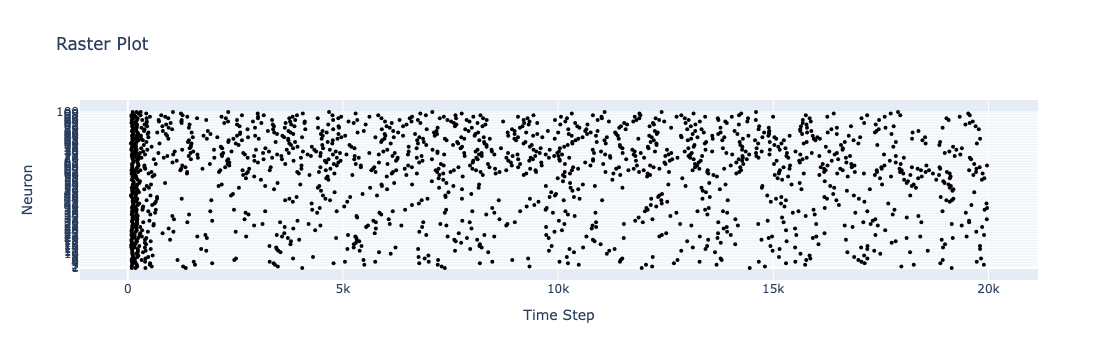

In [100]:
_, fig = firing_rates(firings[:, :Ne], T)
fig.show()

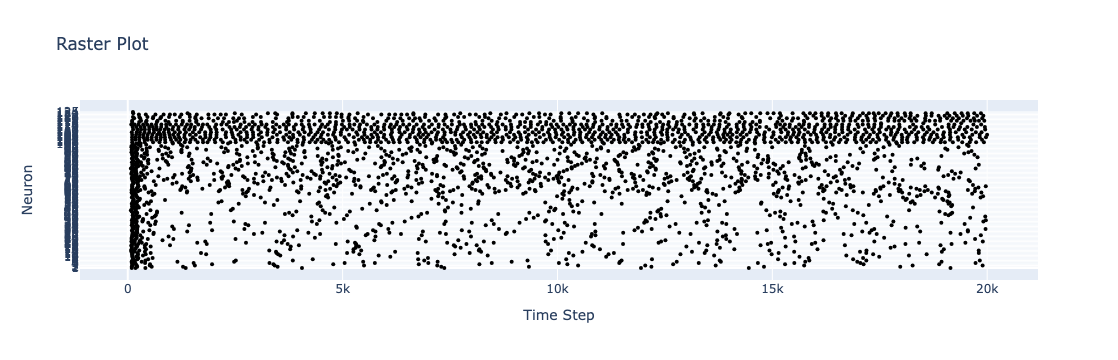

In [101]:
_, fig = firing_rates(firings, T)
fig.show()

In [102]:
np.sum(firings, axis = 0) / 2

array([ 4.5,  5. ,  6.5,  6.5,  8. ,  7. ,  6. ,  4.5,  3. ,  3. ,  5. ,
        6.5,  7. ,  6. ,  5.5,  5. ,  3.5,  5. ,  6.5,  7.5,  8. ,  7. ,
        4.5,  4.5,  3.5,  4.5,  5.5,  7.5,  7.5,  8. ,  6. ,  5. ,  3. ,
        4. ,  5.5,  7.5,  8. ,  7. ,  5. ,  3.5,  4. ,  4.5,  5. ,  8. ,
        8. ,  6.5,  6. ,  4. ,  4. ,  3.5,  5.5,  7.5,  7.5,  7.5,  5.5,
        3.5,  5. ,  6. ,  7.5, 10. , 12.5, 14.5, 14.5, 14. , 12.5, 12. ,
       11. ,  9.5, 11.5, 12. , 14.5, 15.5, 15. , 15. , 13.5, 12. , 11. ,
       10.5, 10.5, 11. , 11.5, 11.5, 14. , 13.5, 13.5, 13.5, 13.5, 12. ,
       11. , 11. , 11. , 11.5, 12. , 12.5, 13.5, 13. , 12. , 11. ,  8. ,
        5.5, 60.5,  0. , 61. ,  0. , 59.5,  0. , 61.5,  0. , 59.5,  0. ,
       60. ,  0. , 60.5,  0. , 61. ,  1.5, 20.5, 38. ,  0. , 35.5, 23. ,
       13.5, 25.5, 30.5,  0.5])